<a href="https://colab.research.google.com/github/codingFerryman/crypto_market_hierarchy_structure/blob/main/src/30m_MST_per_day.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### "2021-04-12" - "2021-06-14", "2021-08-16" - "2021-10-17", 30m, MST per day

In [ ]:
import datetime
from pathlib import Path
import os
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from utils import check_integrity, load_data, datestring_to_timestamp, get_golden_timestamps, my_fillna
import mplfinance as mpf
import numpy as np
import seaborn as sns
import networkx as nx

plt.rcParams.update({'font.size': 22})

In [ ]:
stable_coins = ['UST','PAX','DAI', 'MIM','TSD','UDC','EOSDT','XCH','EUS','XAUT']

In [ ]:
datelist1 = pd.date_range(start="2021-04-12",end="2021-06-14", periods = 64).tolist()
datelist1 = [datelist1[i].strftime('%Y-%m-%d') for i in range(len(datelist1))]
time_range1 = [(datelist1[i], datelist1[i+1]) for i in range(len(datelist1)-1)]
timestamp_range1 = [tuple(map(datestring_to_timestamp, tup)) for tup in time_range1]

datelist2 = pd.date_range(start="2021-08-16",end="2021-10-17", periods = 63).tolist()
datelist2 = [datelist2[i].strftime('%Y-%m-%d') for i in range(len(datelist2))]
time_range2 = [(datelist2[i], datelist2[i+1]) for i in range(len(datelist2)-1)]
timestamp_range2 = [tuple(map(datestring_to_timestamp, tup)) for tup in time_range2]

In [ ]:
data_dir = Path(os.getcwd(), '..', 'data').resolve()
intervals = ['30m']
coins_pass_check_1 = {}

for interval in intervals:
    coins_pass_check_1[interval] = []
    data_interval_dir = Path(data_dir, interval)
    files_path_list = [p for p in data_interval_dir.iterdir() if p.suffix == '.csv']
    for file_path in files_path_list:
        coin_code = file_path.name.split("_")[0]
        #if check_integrity(*time_ranges[0], file_path) is not None:
        coins_pass_check_1[interval].append(coin_code)

In [ ]:
def check_integrity_score_and_load_data(time_range, coins_pass_pre_check, score_threshold, check_intervals=['30m']):
    _coins_integrity = {}
    _coins_in_use = {}
    for _interval in check_intervals:
        _coins_integrity[_interval] = {}
        _coins_in_use[_interval] = {}
        _data_interval_dir = Path(data_dir, _interval)
        for i in time_range: 
            _coins_integrity[_interval][i] = {}
            _coins_in_use[_interval][i] = {}
            _coins_in_use[_interval][i]['data'] = {}
            _coins_in_use[_interval][i]['coin_list'] = None
            _temp_coins_in_use = []
            _temp_coins_in_use_list = []
            for _coin in coins_pass_pre_check['30m']:
                _file_path = Path(_data_interval_dir, f"{_coin}_USD_{_interval}.csv")                
                _c_df = load_data(i[0], i[1], _file_path, fill_na=True)
                if len(_c_df):
                    _coins_integrity[_interval][i][_coin] = len(_c_df[_c_df.is_fill == False]) / len(_c_df)
                    if _coins_integrity[_interval][i][_coin] >= score_threshold:
                        _temp_coins_in_use.append(_c_df)
                        _temp_coins_in_use_list.append(_coin)
                else: 
                    _coins_integrity[_interval][i][_coin] = None
            _coins_in_use[_interval][i]['data'] = pd.concat(_temp_coins_in_use)
            _coins_in_use[_interval][i]['coin_list'] = _temp_coins_in_use_list                            
    return _coins_integrity, _coins_in_use

In [ ]:
integrity_score_range1, coins_in_use_range1 = check_integrity_score_and_load_data(timestamp_range1, coins_pass_check_1, 0.4)

In [ ]:
integrity_score_range2, coins_in_use_range2 = check_integrity_score_and_load_data(timestamp_range2, coins_pass_check_1, 0.4)

In [ ]:
def close_pcr_cm(df, coin_list):
    _tmp_df_pcr_list = []
    for tick in coin_list:
        _tmp_df = df[df.index.get_level_values('coin') == tick].set_index('datetime').copy()['close'].rename(f'{tick}')        
        _tmp_df_pcr = _tmp_df.pct_change().fillna(0)
        _tmp_df_pcr_list.append(_tmp_df_pcr)
    _tmp_pcr_df = pd.concat(_tmp_df_pcr_list, axis=1)
    _tmp_pcr_df_cm = _tmp_pcr_df.corr(method='pearson')
    return _tmp_pcr_df_cm

In [ ]:
# correlation matrix of percentage change of returns
cm_pcr_range1 = {}
for i in timestamp_range1:
    df = coins_in_use_range1['30m'][i]['data']
    coin_list_range1 = coins_in_use_range1['30m'][i]['coin_list']
    cm_pcr_range1[i] = close_pcr_cm(df, coin_list_range1)    

In [ ]:
cm_pcr_range2 = {}
for i in timestamp_range2:
    df = coins_in_use_range2['30m'][i]['data']
    coin_list_range2 = coins_in_use_range2['30m'][i]['coin_list']
    cm_pcr_range2[i] = close_pcr_cm(df, coin_list_range2)  

In [ ]:
def MST_from_cm_pcr(cmpcr): # cm_pcr[time_ranges[0]]
    
    def MST(corr_mat):
        _dist_mx = np.sqrt(2*(1-corr_mat))
        _G = nx.from_numpy_matrix(_dist_mx)
        _M = nx.minimum_spanning_tree(_G,weight='weight')
        return _M

    _MST = MST(cmpcr.to_numpy())
    _tickers_list = list(cmpcr.columns)
    _tickers = {i:list(cmpcr.columns)[i] for i in range(len(list(cmpcr.columns)))}
    # leader, stable, coin_of_interest
    _attr_leader = {i:False for i in range(len(list(cmpcr.columns)))}
    _attr_stable = {i:False for i in range(len(list(cmpcr.columns)))}
    _attr_coin_of_interest = {i:False for i in range(len(list(cmpcr.columns)))}
    nx.set_node_attributes(_MST, values=_tickers, name='ticker')
    nx.set_node_attributes(_MST, values=_attr_leader, name='leader')
    nx.set_node_attributes(_MST, values=_attr_stable, name='stable')
    nx.set_node_attributes(_MST, values=_attr_coin_of_interest, name='coin_of_interest')
    return _MST, _tickers_list, _tickers

In [ ]:
def target_coins(G, coin_of_interest):
    _MST = G[0]
    _tickers_list = G[1]
    _tickers = G[2]
    _coi = coin_of_interest
    # top degree coins
    def topN(N, G):
        _degree = np.array([d for n, d in G.degree()])
        _top_indx = np.argsort(_degree)[-N:]
        _top_degree_ticker = [(G.nodes[i]['ticker'], G.degree(i)) for i in _top_indx[::-1]]
        _node_top_degree_ticker = [_tickers_list.index(i[0]) for i in _top_degree_ticker]                
        return _node_top_degree_ticker, _top_degree_ticker 
    _leader_coins = topN(5, _MST)    
    # stable coins
    _node_stable_coins = [_tickers_list.index(i) for i in stable_coins if i in _tickers_list]
    _stable_coins = [(_MST.nodes[i]['ticker'], _MST.degree(i)) for i in _node_stable_coins]  
    # coins of interest
    _node_coin_of_interest = [_tickers_list.index(i) for i in _coi]
    _coin_of_interest = [(_MST.nodes[i]['ticker'], _MST.degree[i]) for i in _node_coin_of_interest]
    
    for i in range(len(_tickers_list)):
        if i in _node_stable_coins: 
            _MST.nodes[i]['color'] = 'orange'
            _MST.nodes[i]['stable'] = True
        elif i in _leader_coins[0]: 
            _MST.nodes[i]['color'] = 'red'
            _MST.nodes[i]['leader'] = True
        elif i in _node_coin_of_interest: 
            _MST.nodes[i]['color'] = 'green'
            _MST.nodes[i]['coin_of_interest'] = True
        else: _MST.nodes[i]['color'] = 'lightblue'
            
    return _MST, _tickers, _leader_coins[1], _stable_coins, _coin_of_interest

In [ ]:
MST_range1 = {}
for i in range(len(time_range1)):
    MST_range1[time_range1[i]] = {}
    MST_range1[time_range1[i]]['raw'] = MST_from_cm_pcr(cm_pcr_range1[timestamp_range1[i]])
    MST_range1[time_range1[i]]['target'] = target_coins(MST_range1[time_range1[i]]['raw'], ['BTC'])

In [ ]:
MST_range2 = {}
for i in range(len(time_range2)):
    MST_range2[time_range2[i]] = {}
    MST_range2[time_range2[i]]['raw'] = MST_from_cm_pcr(cm_pcr_range2[timestamp_range2[i]])
    MST_range2[time_range2[i]]['target'] = target_coins(MST_range2[time_range2[i]]['raw'], ['BTC'])

In [ ]:
def MST_plot(M, title, fign):
    _graph = M[0]
    _tickers = M[1]
    fig, ax = plt.subplots(1,1,figsize=(10, 10))
    fig.suptitle(fign+'Minimal Spanning Tree of '+title, fontsize=14, y=0.92)
    pos = nx.spring_layout(_graph)
    # todo: use attr stable/leader/coin_of_interest to pin target coins in the plot
    nx.draw(_graph, pos=pos, with_labels=True, labels=_tickers,
            node_size=20, font_size=10, edge_color='lightgray',
            node_color = [_graph.nodes[i]['color'] for i in _graph.nodes()],
            verticalalignment='bottom',alpha=1,ax=ax)

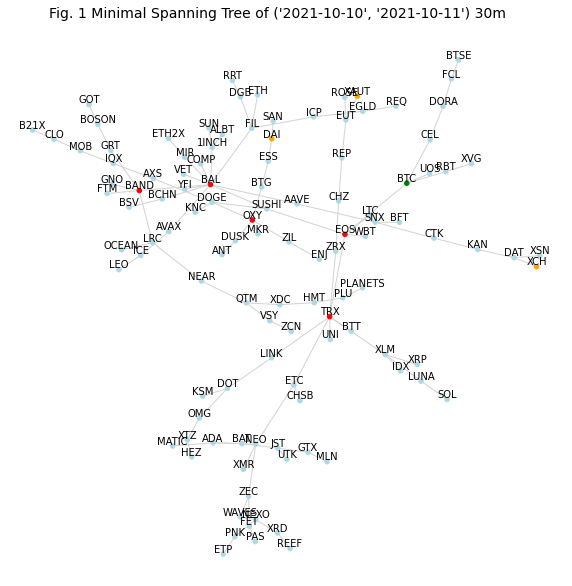

In [ ]:
MST_plot(MST_range2[time_range2[55]]['target'],f'{time_range2[55]} 30m', 'Fig. 1 ')

In [ ]:
# MST[2] = leader_coins, MST[3] = stable_coins, MST[4] = coin_of_interest
MST_range2[time_range2[55]]['target'][2]

[('BAL', 11), ('TRX', 7), ('OXY', 5), ('BAND', 5), ('EOS', 5)]

In [ ]:
MST_range1[time_range1[55]]['target'][2]

[('BTC', 9), ('BAND', 6), ('LINK', 5), ('TRX', 5), ('ETH', 5)]

In [ ]:
# leader board, select target coins
def leader_board(time_range, MST_range):
    _leaders = {}
    _tr = time_range
    _Mr = MST_range
    for i in range(len(_tr)):
        _leaders[_tr[i]] = _Mr[_tr[i]]['target'][2]
    _leader_freq = {}
    for day, leaders_of_day in _leaders.items():
        for tic in leaders_of_day:
            if tic[0] in _leader_freq.keys(): _leader_freq[tic[0]] += 1
            else: _leader_freq[tic[0]] = 1  
    _leader_freq_sorted = list(sorted(_leader_freq.items(), key=lambda item: item[1]))
    _top = _leader_freq_sorted[-5:]
    _top_tic = [i[0] for i in _top]
    return _top, _top_tic

In [ ]:
leader_board_range1 = leader_board(time_range1, MST_range1)

In [ ]:
leader_board_range1

([('EOS', 14), ('NEO', 16), ('LINK', 18), ('ETH', 35), ('TRX', 39)],
 ['EOS', 'NEO', 'LINK', 'ETH', 'TRX'])

In [ ]:
leader_board_range2 = leader_board(time_range2, MST_range2)

In [ ]:
leader_board_range2

([('TRX', 16), ('BTC', 17), ('NEO', 18), ('ETH', 27), ('EOS', 33)],
 ['TRX', 'BTC', 'NEO', 'ETH', 'EOS'])

In [ ]:
coin_of_interest_range1 = leader_board_range1[1].copy()
if 'BTC' not in coin_of_interest_range1: coin_of_interest_range1.append('BTC')

In [ ]:
coin_of_interest_range2 = leader_board_range2[1].copy()
if 'BTC' not in coin_of_interest_range2: coin_of_interest_range2.append('BTC')

In [ ]:
for i in range(len(time_range1)):
    MST_range1[time_range1[i]]['target_leader'] = target_coins(MST_range1[time_range1[i]]['raw'], coin_of_interest_range1)    

In [ ]:
for i in range(len(time_range2)):
    MST_range2[time_range2[i]]['target_leader'] = target_coins(MST_range2[time_range2[i]]['raw'], coin_of_interest_range2)  

In [ ]:
# degree time series of coin_of_interest
def coi_degree_ts(time_range, MST_range, coi_range): # e.g. coin_of_interest_range1
    _tr = time_range
    _Mr = MST_range
    _cr = coi_range
    _coi_d = {}
    for i in range(len(_tr)):
        _coi_d[_tr[i]] = _Mr[_tr[i]]['target_leader'][4]
    _coi_d_df = {}
    for i in _cr:
        _coi_d_df[i] = []
    for i in range(len(_tr)):
        for j in range(len(_cr)):
            _coi_d_df[_cr[j]].append(_coi_d[_tr[i]][j][1])
    _coi_df = pd.DataFrame.from_dict(_coi_d_df)        
    return _coi_df

In [ ]:
coi_d_ts1 = coi_degree_ts(time_range1, MST_range1, coin_of_interest_range1)

In [ ]:
coi_d_ts2 = coi_degree_ts(time_range2, MST_range2, coin_of_interest_range2)

In [ ]:
%matplotlib inline

def plot_coi_d_ts(coi_d_ts):    
    fig, axs = plt.subplots(2, 3, figsize=(20,10))
    _col = coi_d_ts.columns
    for i in range(len(_col)):
        ax = axs.reshape(-1)[i]
        ax.plot(coi_d_ts[_col[i]], label=_col[i])
        ax.legend()

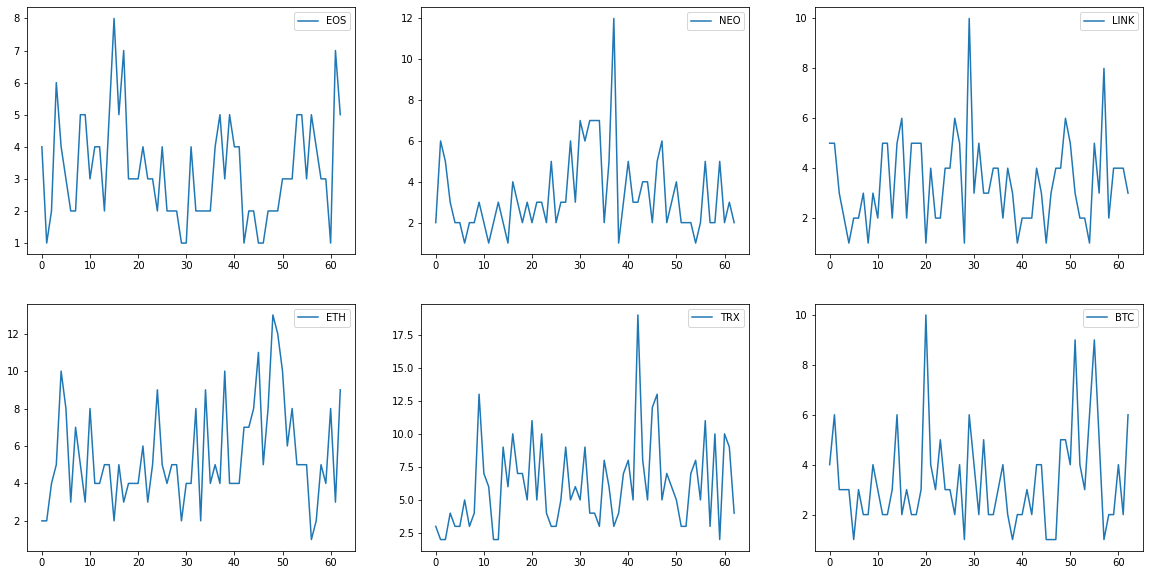

In [ ]:
plot_coi_d_ts(coi_d_ts1)

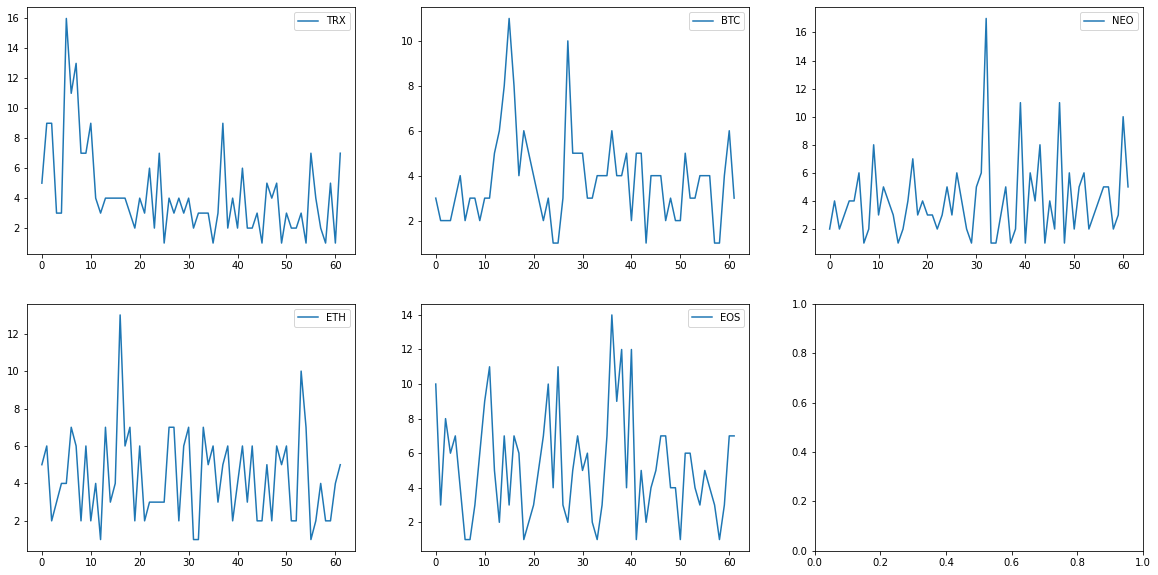

In [ ]:
plot_coi_d_ts(coi_d_ts2)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

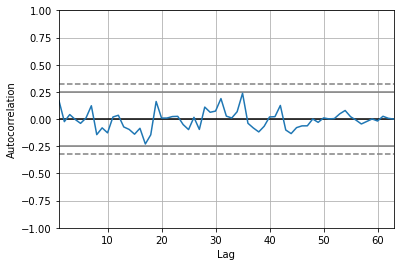

In [ ]:
pd.plotting.autocorrelation_plot(coi_d_ts1['BTC'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

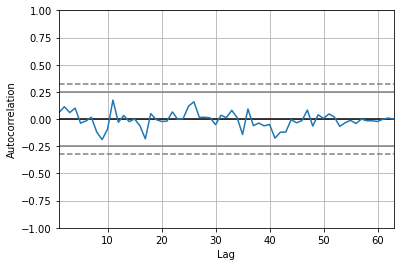

In [ ]:
pd.plotting.autocorrelation_plot(coi_d_ts1['TRX'])

In [ ]:
def jaccard_similarity(g, h):
    _intersec = set(g).intersection(set(h))
    _union = set(g).union(set(h))
    return float(len(_intersec)/len(_union)), _intersec

In [ ]:
def node_index_to_ticker(MST_range): # e.g. MST_range1[time_range1[0]]['target_leader']
    _MST_E = MST_range[0].edges
    _tic = MST_range[1]
    _MST_E_tic = []
    for i in range(len(_MST_E)):
        _e = list(_MST_E(i))[0]
        _et = tuple([_tic[i] for i in _e])
        # also include tuple of reversed nodes
        _etr = tuple((_et[1], _et[0]))
        _MST_E_tic.append(_et)
        _MST_E_tic.append(_etr)
    return _MST_E_tic    

In [ ]:
MST_edge_sim_range1 = {'intersection':[], 'similarity':[]}
for i in range(len(time_range1)-1):
    mste0 = node_index_to_ticker(MST_range1[time_range1[i]]['target_leader'])
    mste1 = node_index_to_ticker(MST_range1[time_range1[i+1]]['target_leader'])
    sim, inter = jaccard_similarity(mste0, mste1)
    MST_edge_sim_range1['intersection'].append(inter)
    MST_edge_sim_range1['similarity'].append(sim)

In [ ]:
# find in intersection the most frequent edges
edge_intersection_range1 = []
for intersec in MST_edge_sim_range1['intersection']:
    edge_intersection_range1.extend(list(intersec))

In [ ]:
from collections import Counter
 
def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(10)

In [ ]:
most_frequent(edge_intersection_range1)

[(('TRX', 'JST'), 28),
 (('JST', 'TRX'), 28),
 (('ETH', 'SUSHI'), 18),
 (('BAL', 'ETH'), 18),
 (('SUSHI', 'ETH'), 18),
 (('ETH', 'BAL'), 18),
 (('ETH', 'BTC'), 14),
 (('BTC', 'ETH'), 14),
 (('BTT', 'TRX'), 9),
 (('TRX', 'BTT'), 9)]

In [ ]:
edge_intersection_range2 = []
for intersec in MST_edge_sim_range2['intersection']:
    edge_intersection_range2.extend(list(intersec))

In [ ]:
most_frequent(edge_intersection_range2)

[(('BTC', 'WBT'), 24),
 (('WBT', 'BTC'), 24),
 (('ETH', 'BTC'), 22),
 (('BTC', 'ETH'), 22),
 (('TRX', 'SUN'), 15),
 (('SUN', 'TRX'), 15),
 (('TRX', 'JST'), 11),
 (('JST', 'TRX'), 11),
 (('EOS', 'LTC'), 9),
 (('LTC', 'EOS'), 9)]

In [ ]:
MST_edge_sim_range2 = {'intersection':[], 'similarity':[]}
for i in range(len(time_range2)-1):
    mste0 = node_index_to_ticker(MST_range2[time_range2[i]]['target_leader'])
    mste1 = node_index_to_ticker(MST_range2[time_range2[i+1]]['target_leader'])
    sim, inter = jaccard_similarity(mste0, mste1)
    MST_edge_sim_range2['intersection'].append(inter)
    MST_edge_sim_range2['similarity'].append(sim)

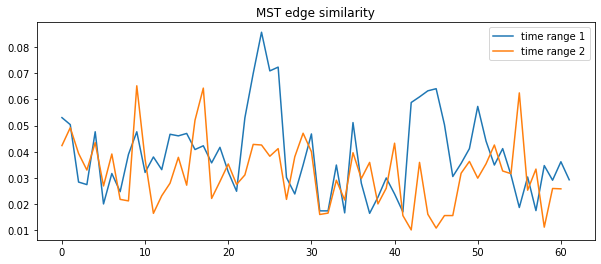

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.set_title('MST edge similarity')
ax.plot(MST_edge_sim_range1['similarity'], label='time range 1')
ax.plot(MST_edge_sim_range2['similarity'], label='time range 2')
ax.legend()
plt.show()

In [ ]:
MST_node_sim_range1 = []
for i in range(len(time_range1)-1):
    mstn0 = MST_range1[time_range1[i]]['target_leader'][1].values()
    mstn1 = MST_range1[time_range1[i+1]]['target_leader'][1].values()
    MST_node_sim_range1.append(jaccard_similarity(mstn0, mstn1))

In [ ]:
MST_node_sim_range2 = []
for i in range(len(time_range2)-1):
    mstn0 = MST_range2[time_range2[i]]['target_leader'][1].values()
    mstn1 = MST_range2[time_range2[i+1]]['target_leader'][1].values()
    MST_node_sim_range2.append(jaccard_similarity(mstn0, mstn1))

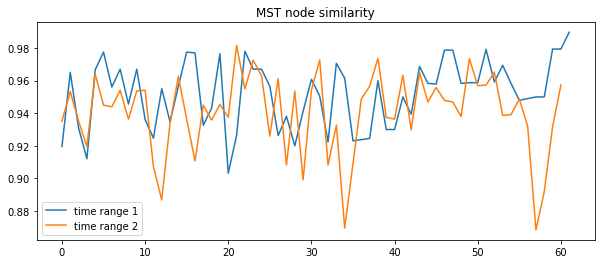

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.set_title('MST node similarity')
ax.plot(MST_node_sim_range1, label='time range 1')
ax.plot(MST_node_sim_range2, label='time range 2')
ax.legend()
plt.show()